# Machine Learning Lecture 3

## Load the Libraries

In [26]:
%matplotlib inline
import sys

# or wherever you have saved the repo
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

### From the Last Lesson (data conditioning / changes)

As a note `%time` will provide processing times. It's a jupyter notebook function.

Ideally only run once to save to disk (takes a while)

In [27]:
# loading the data (large)
%time df_raw = pd.read_csv('/Users/tlee010/kaggle/bulldozers/Train.csv', low_memory=False, parse_dates=["saledate"])
print('load complete')

# transform the data
df_raw.SalePrice = np.log(df_raw.SalePrice)
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
add_datepart(df_raw, 'saledate')
print('transform complete')

# export
df_raw.to_feather('/tmp/raw')
print('export complete')

CPU times: user 1min 8s, sys: 572 ms, total: 1min 8s
Wall time: 1min 8s
load complete
transform complete
export complete


In [28]:
# note, edit the path of the tmp file where necessary
df_raw = pd.read_feather('/tmp/raw')
df_trn, y_trn = proc_df(df_raw, 'SalePrice')

#### Digging into Random Forests for lec 3 + 4

For some datasets they work really well. But how do they actually work. What can we tune, and improve.

Second, how can we interpret the results and learn something about the model

## Review up to this point

### LastLec: Talking about the fastai library

Using state-of-the-art techinques packaged together. The library will wrap existing libraries. Many of sklearn libraries are used under the hood. 

https://github.com/fastai/fastai

#### How to use it

1. Put notebooks in the same directory as fastai. 
2. Symlink it
3. copy the git repo to your dev folder
4. or append the path


####  LastLec: Make a Symlink in command line

In [24]:
!ln -s ../../fastai

####  LastLec: Setup the environment

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 #### LastLec: Understanding Metrics
 
 For the bulldozers dataset, the kaggle says the target metric is RMSE
 
 $$RMSE = sum(log(actuals)-log(preds))^2$$

 #### LastLec: data conditioning
    
1. **Breakout dates:** Date column, replace with a number of columns using `date_part()` which is another fastai custom function

2. **Replace strings with categories**: using `train_cat(dataframe)` that will go through each field and clean. Then follow up and change the levels 

3. **Then separate target and features** - `df, y = prod_df(dataframe, "target field")`

4. **Then traing the model**

```python
# creates a blank model
model = RandomForestRegressor(n_jobs=-1)

# fits the model and sets the coefficients based on 
# data
model.fit(df,y)

# scores the model by generating y_hats
model.score(df,y)

```


## What is R^2? (accuracy)

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).[1]

$$ SS_{res} = \sum{(f_i-\bar{y})^2} $$
$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

**Range of values for R^2 ** - can be less than 1. If you predict infinity for each values, you will get negative. Which means your model is worse than predicting the mean.

#### Careful about overfitting


<img src="https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/overfitting-logreg-ex.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>


## Validation is one of the important part

In [38]:
df, y = proc_df(df_raw, 'SalePrice')

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

### Whats the difference between test and Validation Set

** Test set** - in this context, test is a small subset of train, designed to iterate.

** Validation ** - final score of the best model from the iterations of model design with test data


### LastLec: Ran the Random Forest Regressor

```python
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)
```

#### Output:

```python
CPU times: user 1min 4s, sys: 376 ms, total: 1min 4s
Wall time: 8.56 s
[0.0902435011024215, 0.2507924131328525, 0.98295721706791372, 0.88767491329235182]
```

#### Discussion
|| Train score | Test Score |
|---|------|-------|
|RMSE| 0.090 | 0.251  |
|R^2|0.983  | 0.887 |

We see some good scores, but with the differences, we see that we are overfitting

#### Appendix - how the score worked 

This custom print score gives:

- RMSE_train
- RMSE_test
- Correlation of Train
- Correlation of Test

In [39]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)


## LastLec: Speeding up the processing time - Look at a subset.

Randomly sample from the overall, and need to ensure that our validation and train set are coming from the same distribution. We will work with a smaller subset so that we can iterate much faster through the parameters.

In [43]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

df_trn, y_trn = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

## 3.3 Single Tree

In [46]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5339102994711508, 0.5665289699293733, 0.40769661682316749, 0.42681842757941629]


#### FastAI: Custom function draw_tree

In [49]:
??draw_tree

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

### Tree Analysis

Tree diagram below shows:

- **`field <= criteria`**: the feature + criteria per fields. Criteria can be either a categorical field, or a continous
- **`sample`**: number of samples
- **`value`**: the mean value 
- **`mse`**: the difference


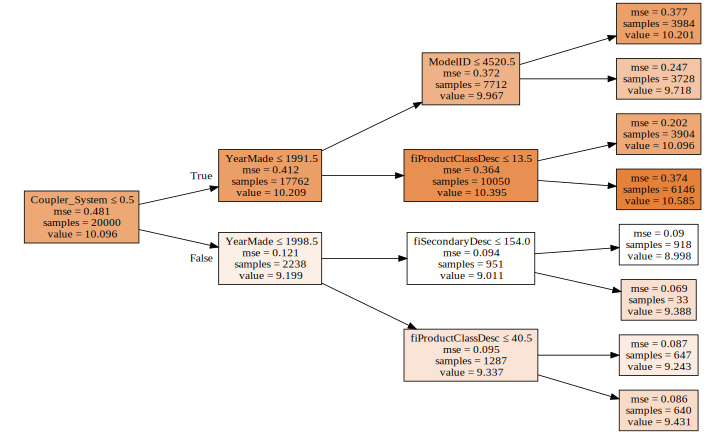

In [47]:
draw_tree(m.estimators_[0], df_trn, precision=3)

#### Discussion of the tree diagram

1. To make a forest, we need to make a tree.
2. If we wanted to make a tree from scratch, we need a binary criteria How?

**What metric ?** Calculate the RMSE times the number of samples. That would give the weighted average RMSE.

**Which variable ? ** Try all variables, try every possible split criteria (within the field) to see which gives the better weighted average RMSE. Then we picked that one.

** Split by 3? ** Not necessary, can just do a 2nd binary split again

** When does the model stop? ** there's some limit given. 

## How to make a Forest: Bagging

#### Bag of little bootstraps

Bagging - what if we made 5 models that were little predictions that were not correlated with each other. That would mean the models found different insights. What if we average teh models? we create an 'ensemble score'.

1. Create 1 tree
2. Take a subset of data
3. Build a deep tree (that will overfit)
4. repeat 100 times

All the trees will be better than nothing, but will all overfit (small samples). But since it is using random samples, will overfit different ways. 

If we average across all the errors, it will reduce. Then we average all them together. 

### Sklearn Library reference for RandomForest

```python
m = RandomForestRegressor(n_estimators=10, max_depth=3, bootstrap=False, n_jobs=-1)
```

**n_estimators** = how many trees

**max_depth** = how deep the tree will be

**bootstrap** = replacements in the random subsets

**n_jobs** = how CPU threads you will use (-1 is all available)


# 3.4 Bagging

![](http://manish-m.com/wp-content/uploads/2012/11/BaggingCropped.png)

### Simple model

In [50]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11761445042573493, 0.27999064711964805, 0.97125720595526177, 0.8599977476692966]


### Each of the Trees are housed in `.estimators_`


We'll grab the predictions for each individual tree, and look at one example. The example down below goes through each of the estimators and pulls out the predictions. Returns the ARRAY, MEAN, ACTUAL

- Note that the array has very bad predictions, but the collective mean is very close to the actual (last two values)



`np.stack` - stacks on a new axis

In [58]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

# sample of the first row of this new data collection
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.04782,  8.9872 ,  9.02401,  9.4727 ,  9.54681,  9.25913,  9.43348,  9.39266,  9.39266,  9.21034,
         9.07108,  9.21034,  9.07681,  9.39266,  9.5819 ,  9.43348,  9.30565,  9.4727 ,  9.04782,  8.9872 ]),
 9.2673237939361446,
 9.1049798563183568)

#### 10 trees, 12000 predictions

In [57]:
preds.shape

(10, 12000)

#### Recent Tree Advances - focus on uncorrelated trees instead of more accurate trees

#### Sklearn
```python
from sklearn.tree import ExtraTreeClassifier, ExtraTreeRegressor
```

Extremely randomized trees. Much faster, more randomness, build more trees and get better generalization. Similar to random forest, but different focus

#### Plot of R^2 vs. number of trees

Based on the plot, it appears that the benefit of adding more trees begins to diminish.

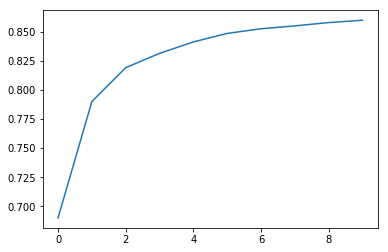

In [52]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

#### What if we have 20?

In [55]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10820721018941977, 0.2700912275188356, 0.97567123765159214, 0.86972264537727961]


#### What if we keep doubling

|trees | R^2|
|-----|-----|
|1|0.409|
|20|0.868|
|40|0.870|
|80|0.873|

## 3.4.2 Out of Bag Score - OOB 


<img src='http://file.scirp.org/Html/6-9101686/036879b1-0ef0-44ea-a061-0e3b48f38e08.jpg' style="width:400px"/>

<img src='https://neupsykey.com/wp-content/uploads/2016/11/A324794_1_En_1_Fig17_HTML.gif' />

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.


#### Average all the trees you didn't use for 

What if you have small datasets. We can run unused rows in different trees. As long as you have enough trees, a sample row will 

#### note the additional option `oob_score` when defining the RandomForest


In [60]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.10225070336002949, 0.26644847729681304, 0.97827597849728065, 0.87321307779312418, 0.84565378571366501]


### GridSearch

```python
from sklearn.model_selection.GridSearchCV
```

A nice implementation to run a lot of different models with different hyper parameters

### Large Datasets



In [62]:
df_trn, y_trn = proc_df(df_raw, 'SalePrice')

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)


Let random forest pull multiple times (randomly) from the superset

In [64]:
set_rf_samples(20000)

### with 10 Trees

In [65]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 8.45 s, sys: 598 ms, total: 9.05 s
Wall time: 4.24 s
[0.23956964398307784, 0.2786502613046347, 0.88005051130538814, 0.86133499128265611, 0.86753169378295814]


### with 40 trees

In [66]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22695440917054677, 0.2629258201187014, 0.89235048562864372, 0.87654336129080646, 0.88085954917203169]


#### FASTAI: Custom rf_samples 

In [67]:
??set_rf_samples

```python
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
```

To reset the parameters

```python
reset_rf_samples()
```

## Guidance

Do your machine learning on a reasonable subsample size.

#### Run a Baseline with 40 with nodes to 1

In [70]:
reset_rf_samples()
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

[0.07839009127394027, 0.2389417161150468, 0.98715727549739707, 0.89803950597792648, 0.90817254019168592]


### Hyper Parameter 1 : require a number of samples per leaf (e.g. 3 rows)

Should cut the number of levels being made. 1,3,5,10,25

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [71]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11502352966490124, 0.23317922874081387, 0.9723491677838787, 0.9028981069020966, 0.9084794157320788]


### Hyper Parameter 2 : max features

Max features, less correlated the better. If every tree always has the same field every time, there won't be much variation to the trees. At every split point. Take a different subset of columns.

#### 0.5 = randomly choose half (default is to choose all), can pass ^2 or log2 or Sqrt, this guarantees variation

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.


In [72]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11919783670771852, 0.22816094374676066, 0.97030580383483711, 0.90703262187844114, 0.91169902407915004]


### Quick Summary of Tree Parameters

<img src='https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png'/>

We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)